In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
import os

In [26]:
SEED = 27
np.random.seed(SEED)

CSV_PATH = "syntetic.csv"   
TEST_RATIO = 0.2

# Network hyperparams
H1, H2, H3 = 15, 15, 10
LEARNING_RATE = 0.05
EPOCHS = 1000
PRINT_EVERY = 100
BATCH_SIZE = None  

NUM_CLASSES = 5

In [27]:
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    X = df[['feature1', 'feature2']].values.astype(float)
    y = df['label'].values.astype(int)
    return X, y

def train_test_split_custom(X, y, test_ratio=0.2):
    N = len(X)
    split_idx = int(N * (1 - test_ratio))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, X_test, y_train, y_test

def zscore_normalize(X_train, X_test):
    mean = X_train.mean(axis=0, keepdims=True)
    std = X_train.std(axis=0, keepdims=True) + 1e-8
    X_train_norm = (X_train - mean) / std
    X_test_norm = (X_test - mean) / std
    return X_train_norm, X_test_norm, mean, std

def to_one_hot(y, num_classes):
    N = y.shape[0]
    one_hot = np.zeros((N, num_classes))
    one_hot[np.arange(N), y] = 1
    return one_hot

In [28]:
class NeuralNetworkMultiClass:
    def __init__(self, input_dim, h1, h2, h3, num_classes, learning_rate=0.01, seed=0):
        rng = np.random.default_rng(seed)
        self.learning_rate = learning_rate

        # random initialization 
        self.W1 = rng.normal(0, 1.0 / np.sqrt(input_dim), size=(input_dim, h1))
        self.b1 = np.zeros((1, h1))

        self.W2 = rng.normal(0, 1.0 / np.sqrt(h1), size=(h1, h2))
        self.b2 = np.zeros((1, h2))

        self.W3 = rng.normal(0, 1.0 / np.sqrt(h2), size=(h2, h3))
        self.b3 = np.zeros((1, h3))

        self.W4 = rng.normal(0, 1.0 / np.sqrt(h3), size=(h3, num_classes))
        self.b4 = np.zeros((1, num_classes))

    # Activation functions
    def relu(self, z):
        return np.maximum(0, z)

    def relu_deriv(self, z):
        return (z > 0).astype(float)

    def softmax(self, z):
        z_shifted = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(z_shifted)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # Forward
    def feedForward(self, X):
        self.X = X

        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)

        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.relu(self.Z2)

        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = self.relu(self.Z3)

        self.Z4 = self.A3 @ self.W4 + self.b4
        self.A4 = self.softmax(self.Z4)

        return self.A4

    # Loss (categorical cross-entropy)
    def compute_loss(self, Y_true_one_hot, Y_pred_probs):
        eps = 1e-9
        N = Y_true_one_hot.shape[0]
        log_probs = -np.log(Y_pred_probs + eps)
        loss = np.sum(Y_true_one_hot * log_probs) / N
        return loss

    # Backpropagation (batch gradient descent)
    def backPropagation(self, Y_true_one_hot, Y_pred_probs):
        N = Y_true_one_hot.shape[0]
        lr = self.learning_rate

        # Gradient at output layer: softmax + cross-entropy
        dZ4 = (Y_pred_probs - Y_true_one_hot) / N
        dW4 = self.A3.T @ dZ4
        db4 = np.sum(dZ4, axis=0, keepdims=True)

        # Backprop into Hidden 3
        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * self.relu_deriv(self.Z3)
        dW3 = self.A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)

        # Backprop into Hidden 2
        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * self.relu_deriv(self.Z2)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)

        # Backprop into Hidden 1
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_deriv(self.Z1)
        dW1 = self.X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)

        # gradient descent
        self.W4 -= lr * dW4
        self.b4 -= lr * db4

        self.W3 -= lr * dW3
        self.b3 -= lr * db3

        self.W2 -= lr * dW2
        self.b2 -= lr * db2

        self.W1 -= lr * dW1
        self.b1 -= lr * db1

    def predict(self, X):
        probs = self.feedForward(X)
        preds = np.argmax(probs, axis=1)
        return preds, probs

In [29]:
def plot_dataset(X, y, title="Synthetic 5-Class Dataset", savepath=None):
    plt.figure(figsize=(6,5))
    sc = plt.scatter(X[:,0], X[:,1], c=y, cmap="tab10", s=18, alpha=0.8)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    cbar = plt.colorbar(sc, ticks=range(NUM_CLASSES))
    cbar.set_label("Class")
    if savepath: plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_loss_acc(losses, accs, save_prefix=None):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.plot(accs)
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    if save_prefix:
        plt.savefig(save_prefix + "_loss_acc.png", bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, savepath=None):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if savepath: plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_decision_boundary(nn, X_train, y_train, X_mean, X_std, title="Decision Boundary", savepath=None):
    x_min, x_max = X_train[:,0].min() - 1.0, X_train[:,0].max() + 1.0
    y_min, y_max = X_train[:,1].min() - 1.0, X_train[:,1].max() + 1.0
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_norm = (grid_points - X_mean) / X_std
    Z, _ = nn.predict(grid_norm)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(NUM_CLASSES+1)-0.5, cmap="tab10")
    sc = plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="tab10", edgecolor='k', s=18)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    cbar = plt.colorbar(sc, ticks=range(NUM_CLASSES))
    cbar.set_label("Class")
    if savepath: plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_roc_multiclass(y_test_onehot, y_score, savepath=None):
    plt.figure(figsize=(8,6))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.3f})")

    # micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.3f})", linestyle='--', linewidth=2, color='k')

    plt.plot([0,1], [0,1], 'k--', linewidth=0.8)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC curves (one-vs-rest)')
    plt.legend(loc='lower right', fontsize='small')
    if savepath: plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_probability_histograms(y_true, y_probs, save_prefix=None):
    plt.figure(figsize=(12, 8))
    for i in range(NUM_CLASSES):
        plt.subplot(3, 2, i+1)
        probs_for_class = y_probs[y_true == i, i]
        plt.hist(probs_for_class, bins=20, alpha=0.8)
        plt.title(f"Predicted probability for true class {i} (n={len(probs_for_class)})")
        plt.xlim(0,1)
        plt.xlabel("Predicted probability")
        plt.ylabel("Count")
    plt.tight_layout()
    if save_prefix: plt.savefig(save_prefix + "_prob_hist.png", bbox_inches='tight')
    plt.show()

In [30]:
def main():
    outdir = "nn_outputs"
    os.makedirs(outdir, exist_ok=True)

    X, y = load_data(CSV_PATH)
    X, y = shuffle(X, y, random_state=SEED)

    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Unique classes:", np.unique(y))

    # Visualize dataset 
    plot_dataset(X, y, title="Synthetic 5-Class Dataset (raw)", savepath=os.path.join(outdir, "dataset_raw.png"))

    # Train-test split 
    X_train, X_test, y_train, y_test = train_test_split_custom(X, y, test_ratio=TEST_RATIO)
    print("Train size:", X_train.shape[0])
    print("Test size:", X_test.shape[0])

    # Standardize using training stats
    X_train_norm, X_test_norm, X_mean, X_std = zscore_normalize(X_train, X_test)

    # One-hot encoding for training targets
    Y_train_one_hot = to_one_hot(y_train, NUM_CLASSES)
    Y_test_one_hot = to_one_hot(y_test, NUM_CLASSES)

    print("One-hot label shape (train):", Y_train_one_hot.shape)
    print("One-hot label shape (test):", Y_test_one_hot.shape)

    # Instantiate network
    input_dim = X_train_norm.shape[1]
    nn = NeuralNetworkMultiClass(
        input_dim=input_dim,
        h1=H1,
        h2=H2,
        h3=H3,
        num_classes=NUM_CLASSES,
        learning_rate=LEARNING_RATE,
        seed=SEED
    )

    # Training loop
    train_losses = []
    train_accuracies = []

    for epoch in range(EPOCHS):
        # Forward pass
        probs = nn.feedForward(X_train_norm)

        # Loss
        loss = nn.compute_loss(Y_train_one_hot, probs)
        train_losses.append(loss)

        # Accuracy
        train_preds = np.argmax(probs, axis=1)
        train_acc = np.mean(train_preds == y_train)
        train_accuracies.append(train_acc)

        # Backprop 
        nn.backPropagation(Y_train_one_hot, probs)

        if (epoch + 1) % PRINT_EVERY == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {loss:.6f} - Train Acc: {train_acc:.4f}")

    plot_loss_acc(train_losses, train_accuracies, save_prefix=os.path.join(outdir, "train"))

    # Evaluate on test set
    y_test_pred, test_probs = nn.predict(X_test_norm)
    test_acc = np.mean(y_test_pred == y_test)
    print(f"\nTest accuracy: {test_acc:.4f}\n")

    # Classification report
    class_names = [f"Class {i}" for i in range(NUM_CLASSES)]
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    print("Confusion Matrix:\n", cm)
    plot_confusion_matrix(cm, class_names, savepath=os.path.join(outdir, "confusion_matrix.png"))

    # Plot test true vs predicted scatter
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    sc1 = plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="tab10", s=20, alpha=0.8)
    plt.title("Test Data - TRUE Labels")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(sc1, ticks=range(NUM_CLASSES))

    plt.subplot(1,2,2)
    sc2 = plt.scatter(X_test[:,0], X_test[:,1], c=y_test_pred, cmap="tab10", s=20, alpha=0.8)
    plt.title("Test Data - PREDICTED Labels")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(sc2, ticks=range(NUM_CLASSES))

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "test_true_vs_pred.png"), bbox_inches='tight')
    plt.show()

    # Decision boundary 
    plot_decision_boundary(nn, X_train, y_train, X_mean, X_std, title="Decision Boundary and Training Data", savepath=os.path.join(outdir, "decision_boundary.png"))

    # ROC curves (one-vs-rest)
    plot_roc_multiclass(Y_test_one_hot, test_probs, savepath=os.path.join(outdir, "roc_multiclass.png"))

    # Per-class predicted probability histograms
    plot_probability_histograms(y_test, test_probs, save_prefix=os.path.join(outdir, "probs"))

    # Save a small sample of predictions
    sample_n = min(10, X_test.shape[0])
    sample_df = pd.DataFrame(X_test[:sample_n], columns=["feature1", "feature2"])
    sample_df["true_label"] = y_test[:sample_n]
    sample_df["pred_label"] = y_test_pred[:sample_n]
    sample_df["pred_probs"] = [np.round(p, 3).tolist() for p in test_probs[:sample_n]]
    sample_df.to_csv(os.path.join(outdir, "sample_predictions.csv"), index=False)
    print("Saved sample_predictions.csv")

    # Decision boundary with test points marked
    plt.figure(figsize=(7,6))
    x_min, x_max = X_train[:,0].min() - 1.0, X_train[:,0].max() + 1.0
    y_min, y_max = X_train[:,1].min() - 1.0, X_train[:,1].max() + 1.0
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_norm = (grid_points - X_mean) / X_std
    Z, _ = nn.predict(grid_norm)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.25, levels=np.arange(NUM_CLASSES+1)-0.5, cmap="tab10")
    plt.scatter(X_test[:,0], X_test[:,1], c=y_test, cmap="tab10", s=25, edgecolor='k', alpha=0.9)
    plt.title("Decision Boundary with Test Points (overlay)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar()
    plt.savefig(os.path.join(outdir, "decision_boundary_with_test.png"), bbox_inches='tight')
    plt.show()

    # Custom test points 
    custom_points = np.array([
        [-4, -1],
        [-4, 4],
        [0, 0],
        [2, -4],
        [4, 1],
        [0, 3]
    ])
    custom_norm = (custom_points - X_mean) / X_std
    preds_custom, probs_custom = nn.predict(custom_norm)
    print("\nCustom test points classification:")
    for pt, pc in zip(custom_points, preds_custom):
        print(f" Input {pt} -> Predicted Class {pc}")

    # Plot custom points in normalized space overlayed on training norm
    plt.figure(figsize=(8,6))
    sc = plt.scatter(X_train_norm[:,0], X_train_norm[:,1], c=y_train, cmap="tab10", alpha=0.3, s=20)
    plt.scatter(custom_norm[:,0], custom_norm[:,1], c=preds_custom, cmap="tab10", marker='X', s=200, edgecolors='black', linewidths=2)
    plt.title("Custom Test Points Classified by Neural Network (normalized)")
    plt.xlabel("Feature 1 (normalized)")
    plt.ylabel("Feature 2 (normalized)")
    plt.colorbar(sc, ticks=range(NUM_CLASSES))
    plt.savefig(os.path.join(outdir, "custom_test_points.png"), bbox_inches='tight')
    plt.show()

    print("\nAll outputs saved under folder:", outdir)

X shape: (1500, 2)
y shape: (1500,)
Unique classes: [0 1 2 3 4]


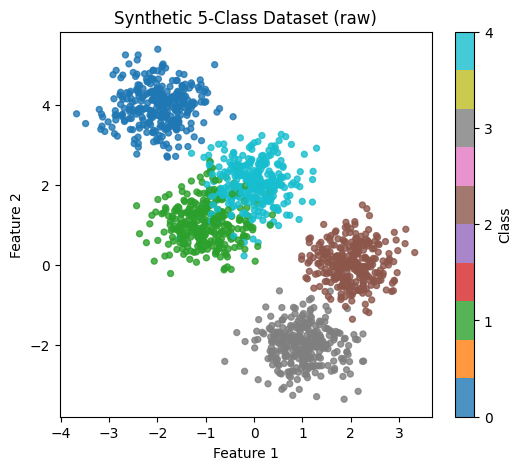

Train size: 1200
Test size: 300
One-hot label shape (train): (1200, 5)
One-hot label shape (test): (300, 5)
Epoch 1/1000 - Loss: 1.572375 - Train Acc: 0.2325
Epoch 100/1000 - Loss: 0.504539 - Train Acc: 0.9050
Epoch 200/1000 - Loss: 0.223663 - Train Acc: 0.9508
Epoch 300/1000 - Loss: 0.162325 - Train Acc: 0.9550
Epoch 400/1000 - Loss: 0.140953 - Train Acc: 0.9583
Epoch 500/1000 - Loss: 0.129844 - Train Acc: 0.9583
Epoch 600/1000 - Loss: 0.123301 - Train Acc: 0.9583
Epoch 700/1000 - Loss: 0.118873 - Train Acc: 0.9583
Epoch 800/1000 - Loss: 0.115635 - Train Acc: 0.9583
Epoch 900/1000 - Loss: 0.113156 - Train Acc: 0.9600
Epoch 1000/1000 - Loss: 0.111204 - Train Acc: 0.9600


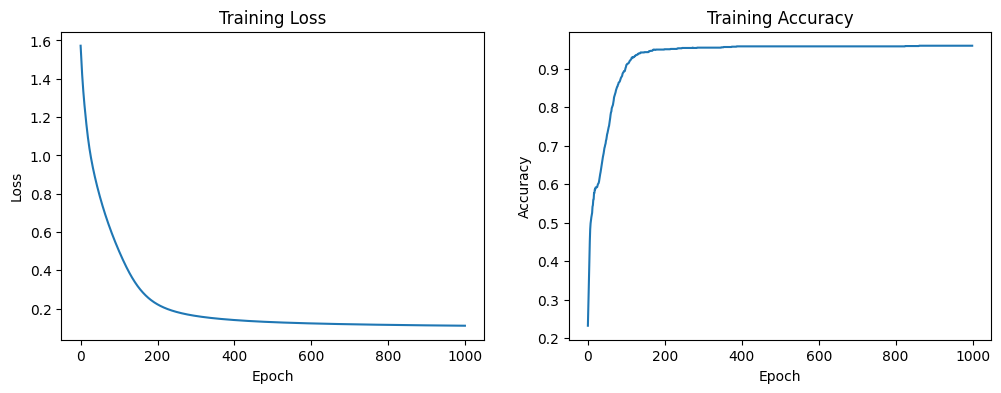


Test accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99        75
     Class 1       0.89      0.96      0.92        49
     Class 2       1.00      1.00      1.00        60
     Class 3       1.00      1.00      1.00        52
     Class 4       0.95      0.89      0.92        64

    accuracy                           0.97       300
   macro avg       0.96      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300

Confusion Matrix:
 [[74  0  0  0  1]
 [ 0 47  0  0  2]
 [ 0  0 60  0  0]
 [ 0  0  0 52  0]
 [ 1  6  0  0 57]]


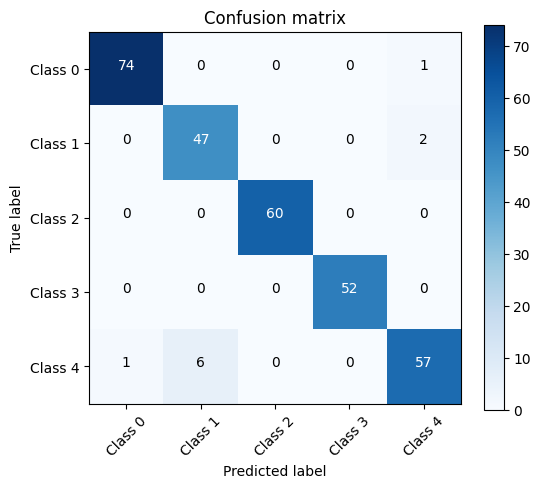

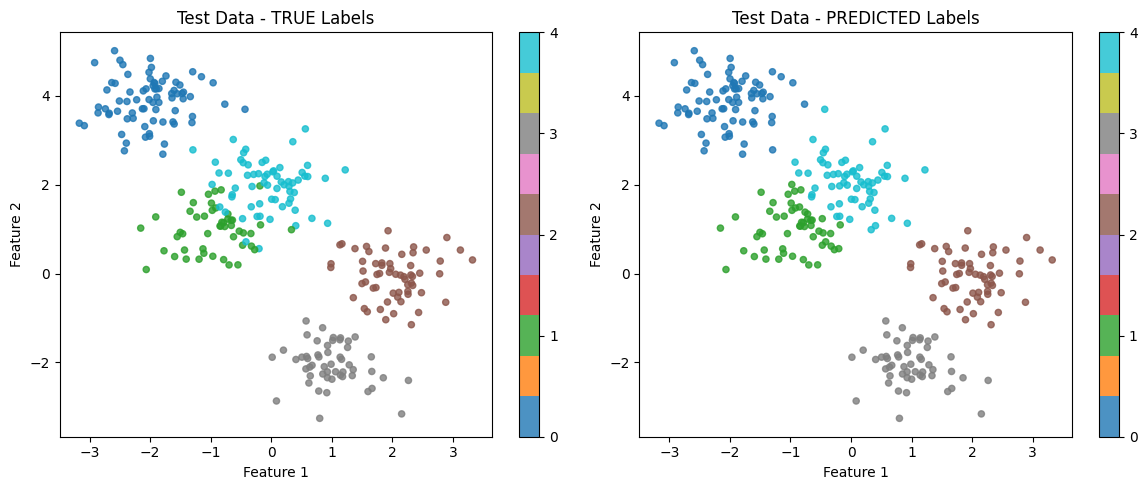

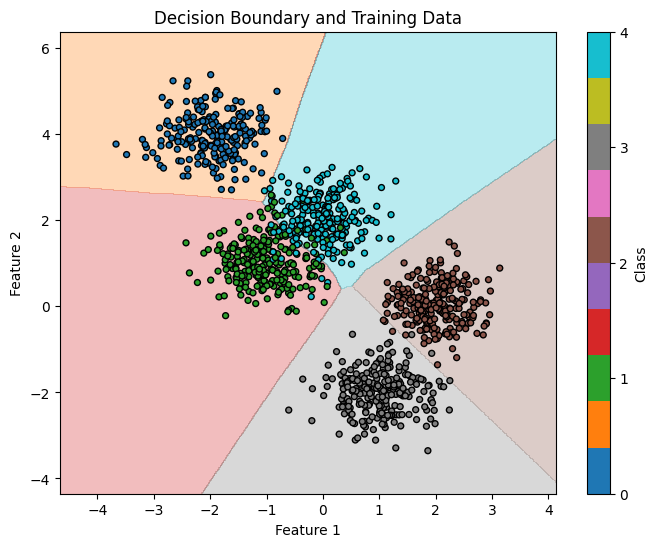

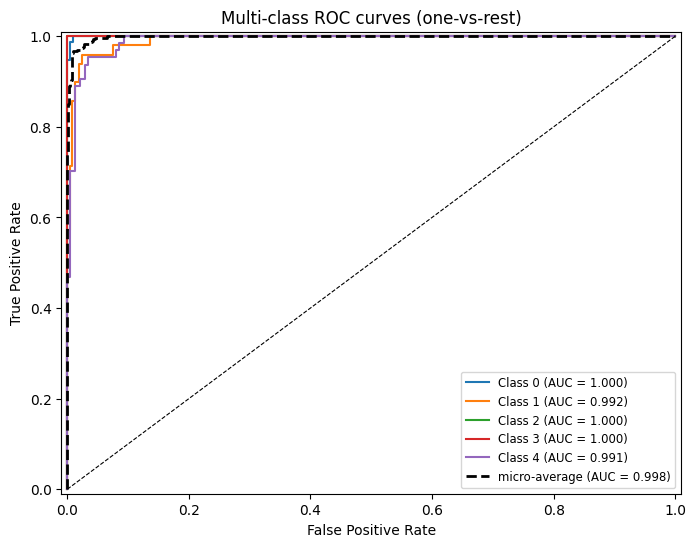

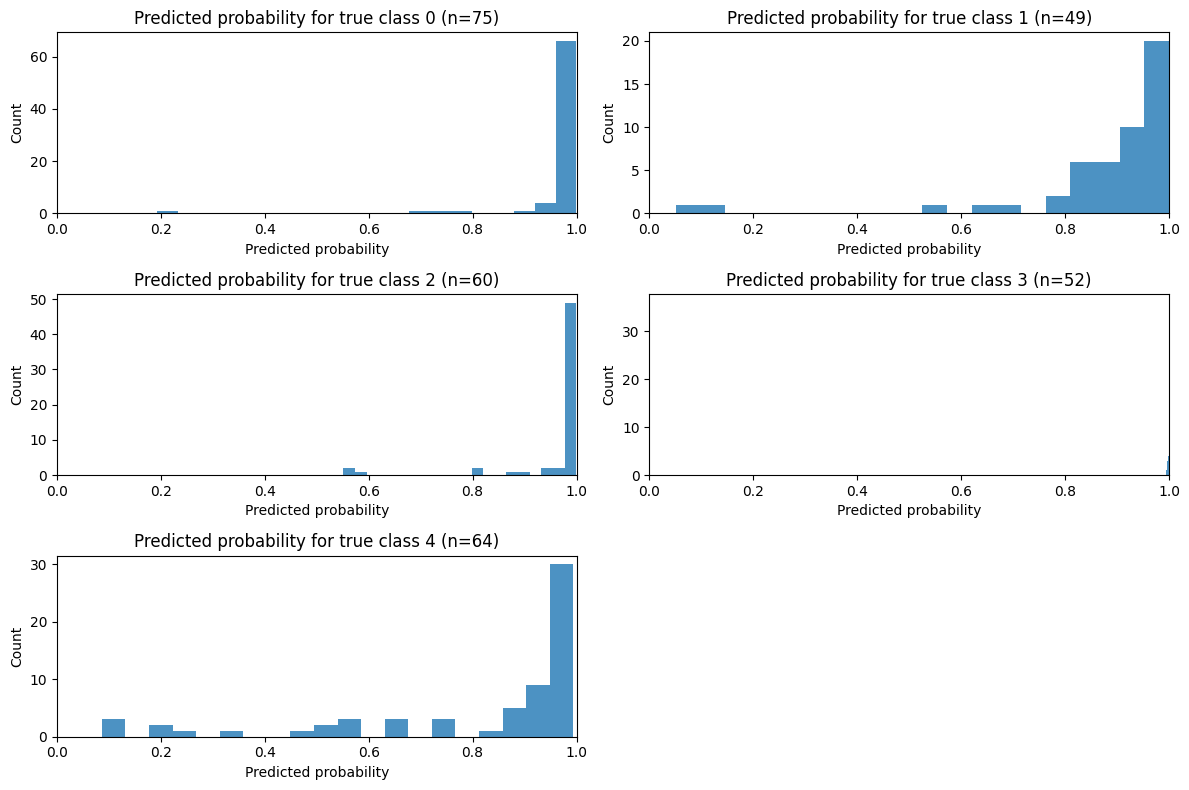

Saved sample_predictions.csv


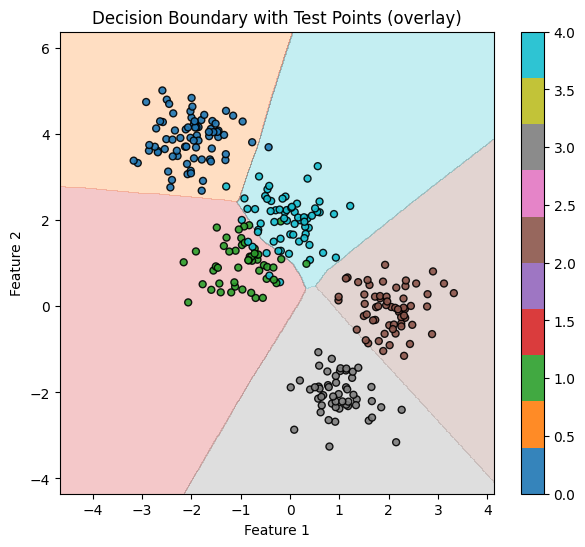


Custom test points classification:
 Input [-4 -1] -> Predicted Class 1
 Input [-4  4] -> Predicted Class 0
 Input [0 0] -> Predicted Class 1
 Input [ 2 -4] -> Predicted Class 3
 Input [4 1] -> Predicted Class 2
 Input [0 3] -> Predicted Class 4


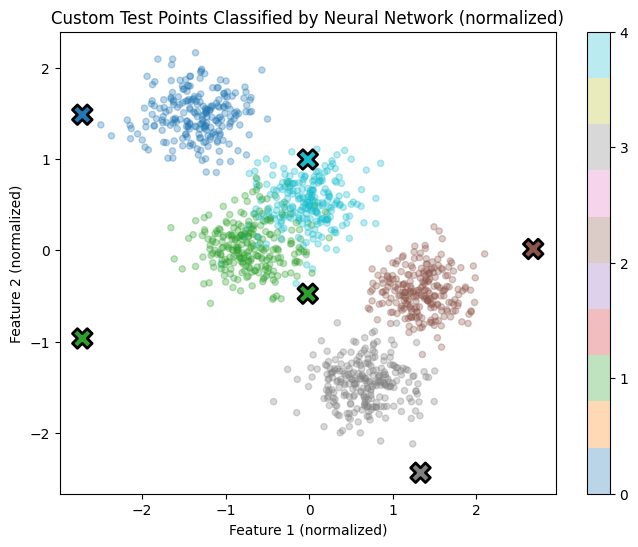


All outputs saved under folder: nn_outputs


In [31]:
if __name__ == "__main__":
    main()

## **Conclusion**

In this assignment, we built and trained a multi-class neural network entirely from scratch using NumPy. The goal was to extend a simple feed-forward model into a deeper architecture with three hidden layers and enable it to classify data into five separate classes. All computations—including forward pass, backpropagation, gradient updates, and softmax probability handling—were implemented manually without relying on deep learning frameworks.

### **Dataset & Preprocessing**

A synthetic 5-class dataset was used for training and evaluation. Each class formed a distinct cluster, making the data visually clear but still non-linear. After generating the dataset, it was shuffled and split into **1200 training** and **300 testing** samples.  
To stabilize training, Z-score normalization was applied using training-set statistics, and labels were converted into one-hot vectors for compatibility with the softmax output layer.

### **Model Architecture**

The network consisted of:
- **Input Layer:** 2 features  
- **Hidden Layers:** 15 → 15 → 10 neurons, all using ReLU activation  
- **Output Layer:** 5 neurons with softmax for multi-class prediction  

This structure allowed the model to learn complex non-linear separation between the clusters.

### **Training**

The model was trained for **1000 epochs** using batch gradient descent with a learning rate of **0.05**. Throughout training, the loss decreased steadily, and accuracy improved rapidly during the initial epochs before stabilizing near 96%.  
This showed that the manually implemented forward and backward passes were functioning correctly.

### **Results & Analysis**

The trained network achieved a **test accuracy of 96.67%**, with minimal misclassifications across the five classes.

Key visualizations included:
- **Training Loss Curve:** Demonstrated smooth and consistent convergence.  
- **Training Accuracy Curve:** Showed rapid learning and early stabilization.  
- **Confusion Matrix:** Most samples correctly predicted, with errors mainly near class boundaries.  
- **Decision Boundary Plot:** Confirmed that the network successfully learned meaningful non-linear regions separating all five classes.  
- **Probability Histograms & Scatter Plots:** Provided deeper insight into model confidence and class behavior.

### **Final Remarks**

Overall, this project demonstrated that a fully manual neural network—with only NumPy—can effectively solve a non-linear multi-class classification task. Proper preprocessing, stable activation functions, and careful gradient implementation played crucial roles in achieving high accuracy. The results confirm that the model learned strong decision boundaries and generalized well on unseen data.

